In [11]:
import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as plticker
import hr_edl_data.plot as mcd_plt
import hr_edl_data.tournament as mcd_tournament

div_color_palette = mcd_plt.diverging_color_palette()
seq_color_palette = mcd_plt.sequential_color_palette()

date = 'may10_2021'

## Color Selection

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


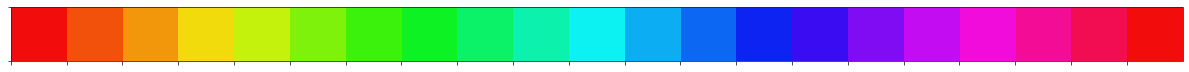

In [12]:
color_palettes = [colorsys.hls_to_rgb(f, 0.5, 0.9) for f in np.arange(0, 1.05, 0.05)]
print(np.arange(0, 1.05, 0.05))
sns.palplot(color_palettes)

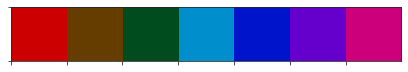

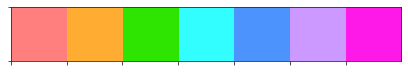

In [13]:
dark_hues = [0, 0.1, 0.4, 0.55, 0.65, 0.75, 0.9]
dark_lightness = [0.4, 0.2, 0.15, 0.4, 0.4, 0.4, 0.4]
light_hues = [1, 0.1, 0.3, 0.5, 0.6, 0.75, 0.85]
light_lightness = [0.75, 0.6, 0.45, 0.6, 0.65, 0.8, 0.55]
dark_colors = [colorsys.hls_to_rgb(h, dark_lightness[i], 1) for i, h in enumerate(dark_hues)]
sns.palplot(dark_colors)
light_colors = [colorsys.hls_to_rgb(h, light_lightness[i], 1) for i, h in enumerate(light_hues)]
sns.palplot(light_colors)

## Configuration

In [85]:
data = mcd_tournament.Data.load()
data.data = data.data.query(f'col_alg == {list(all_algs)} & row_alg == {list(all_algs)}')
data.games()

['leduc',
 'goofspiel',
 'goofspiel_ascending',
 'random_goofspiel',
 'goofspiel_3p',
 'goofspiel_ascending_3p',
 'sheriff',
 'tiny_bridge',
 'tiny_hanabi']

In [86]:
# Setting algorithm comparison groups
hsr_alg_comparisons = (('CFR', 'A-EFR_IN', 'CFR_IN', 'CFR_EX+IN'),)
rla_alg_comparisons = (
    ('CFR', 'A-EFR_IN', 'CFR_IN', 'CFR_EX+IN'),  # Weak algorithms
    ("BPS-EFR", "CFPS-EFR", "CSPS-EFR", 'TIPS-EFR', 'BEHAV-EFR'),  # Strong algorithms
    ("CFPS-EFR", 'TIPS-EFR', "CFPS-EFR_EX+IN", 'TIPS-EFR_EX+IN'),  # Strong EX+IN alternatives
)
nf_algs = ('CFR', 'CFR_IN', 'CFR_EX+IN')
alg_comparisons = rla_alg_comparisons
all_algs = set()
for alg_group in alg_comparisons:
    all_algs = all_algs.union({alg for alg in alg_group})
print(all_algs)

# Setup algorithm specific colors
cf_color_idx = 3
act_color_idx = 6
l1_ps_color_idx = 0
l2_ps_color_idx = 4
alg_color = {
    'CFR': dark_colors[cf_color_idx],
    'A-EFR_IN': dark_colors[act_color_idx],
    'CFR_IN': light_colors[cf_color_idx],
    "BPS-EFR": dark_colors[l1_ps_color_idx],
    "CFPS-EFR": light_colors[l1_ps_color_idx],
    "CSPS-EFR": dark_colors[l2_ps_color_idx],
    'TIPS-EFR': light_colors[l2_ps_color_idx],
    'BEHAV-EFR': (0, 0, 0),
    'CFR_EX+IN': dark_colors[2],
    "CFPS-EFR_EX+IN": dark_colors[1],
    'TIPS-EFR_EX+IN': dark_colors[5],
}
            
learning_curve_query_string = 'game_tag == "{game}" & mode == "{mode}"\
    & col_alg == {col_algs}\
    & row_alg == {algs}'

# Load data and exclude algorithms not in any comparison group
data.data = data.data.query(f'col_alg == {list(all_algs)} & row_alg == {list(all_algs)}')

{'CFR', 'A-EFR_IN', 'BPS-EFR', 'TIPS-EFR', 'CFR_EX+IN', 'CFPS-EFR', 'BEHAV-EFR', 'CSPS-EFR', 'TIPS-EFR_EX+IN', 'CFPS-EFR_EX+IN', 'CFR_IN'}


In [87]:
avg_learning_curve_ylabel = r'avg.\ payoff'
inst_learning_curve_ylabel = 'payoff'

## Game Specific Functions

In [88]:
def is_goofspiel(game_tag):
    return game_tag[:len('goofspiel')] == 'goofspiel' or game_tag == 'random_goofspiel'

def is_leduc(game_tag):
    return game_tag == 'leduc'

def goofspiel_score_to_win_percentage(df):
    return (df + 1.) / 2.0 * 100

def leduc_score_to_milli_antes(df):
    return df * 1000

def set_learning_curve_ylabel(game_tag, ax, avg=True):
    if is_goofspiel(game_tag):
        ax.set_ylabel(r'avg.\ win \%' if avg else r'win \%')
    elif is_leduc(game_tag):
        ax.set_ylabel(
            fr'{avg_learning_curve_ylabel if avg else inst_learning_curve_ylabel} (mbb)')
    else:
        ax.set_ylabel(
            fr'{avg_learning_curve_ylabel if avg else inst_learning_curve_ylabel}')

## Data Functions

In [98]:
def learning_curve_data(game_tag, df, cumsum=True):
    _df = df.pivot(index=['col_alg', 'row_alg'], columns='t', values='value')
    normalizer = 1.0
    if cumsum:
        _df = _df.cumsum(axis=1)
        normalizer += _df.columns.to_numpy()
    _df = (_df.mean(level=1) / normalizer).T.sort_index(axis=1, key=mcd_tournament.alg_sort_keys)
    if is_leduc(game_tag):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game_tag):
        _df = goofspiel_score_to_win_percentage(_df)
    return _df

def learning_curve_runtime_data(df):
    df_milliseconds = df.pivot(index=['col_alg', 'row_alg'], columns='t', values='milliseconds')
    _df = df_milliseconds.mean(level=1).T.sort_index(axis=1, key=mcd_tournament.alg_sort_keys)
    return _df.cumsum()

## Plotting Functions

In [163]:
def sharex_and_y_in_row(axes_list):
    shared_x = axes_list[0].get_shared_x_axes()
    shared_y = axes_list[0].get_shared_y_axes()
    for ax in axes_list[1:]:
        shared_x.join(axes_list[0], ax)
        shared_y.join(axes_list[0], ax)
        
def sharex_in_row(axes_list):
    for j, ax in enumerate(axes_list[1:]):
        axes_list[j - 1].sharex(ax)

def learning_curve_figsize(games, alg_comparisons):
    return (5 + 1)/1.4 * len(alg_comparisons), 3.5/1.4 * len(games)

def learning_curves_adjust_spacing():
    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0.1, hspace=0.5)

def learning_curves_subplots(games, alg_comparisons):
    return plt.subplots(
        len(games),
        len(alg_comparisons),
        squeeze=False,
        figsize=learning_curve_figsize(games, alg_comparisons)
#         gridspec_kw={
#             'height_ratios': [1, 1, 1, 1, 1, 1, 1, 1, 1.5]}
#             'width_ratios': [0.25, 1, 1]}
    )

def learning_curves_legend(ax, ncol=2):
    ax.legend(
        ncol=ncol,
        fontsize='x-small',
        columnspacing=0.5,
        labelspacing=0.25,
        handletextpad=0.4,
        handlelength=0.5)
    
def is_int(n):
    return np.round(n) == n

def learning_curves_xticks(ax):
    _, end = ax.get_xlim()
    int_start = 0
    margin = (end - int_start) / 30.
    num_xticks = 5
    interval = (end - int_start) / float(num_xticks)
    return [
        int_start + i * interval for i in range(int_start, num_xticks + 1)
    ]

def learning_curves_set_xticks(ax, xticks):
    ax.xaxis.set_major_locator(plticker.FixedLocator(xticks))
    if all([is_int(n) for n in xticks]):
        ax.xaxis.set_major_formatter(plticker.FormatStrFormatter('%d'))
    else:
        ax.xaxis.set_major_formatter(plticker.FormatStrFormatter('%0.1f'))

def learning_curves_set_yticks(ax):
    loc = plticker.LinearLocator(4)
    ax.yaxis.set_major_locator(loc)
    ax.yaxis.set_major_formatter(plticker.FormatStrFormatter('%0.1f'))

def hide_xtick_labels(ax):
    ax.set(xticklabels=[])
def hide_ytick_labels(ax):
    ax.set(yticklabels=[])

## Learning Curves

### Runtime

In [164]:
runtime_games = [game for game in data.games() if game != 'tiny_hanabi']

def each_game_in_runtime_learning_curve(verbose=False):
    for i, game_tag in enumerate(
        sorted(runtime_games, key=mcd_tournament.game_sort_key)
    ):
        if verbose: print(game_tag)
        yield i, game_tag

def runtime_learning_curve_data(game_tag, df, cumsum=True):
    return learning_curve_data(game_tag, df), learning_curve_runtime_data(df)

def plot_runtime_learning_curves(ax, game, mode, alg_group, col_algs, lw=2, alpha=0.8):
    ax.grid("on")
    _df, _df_runtime = runtime_learning_curve_data(
        game,
        data.data.query(
            learning_curve_query_string.format(
                game=game,
                mode=mode,
                algs=alg_group,
                col_algs=col_algs)))
    time_scale = 1000.
    for alg in _df.columns:
        ax.plot(
            _df_runtime[alg] / time_scale,
            _df[alg],
            lw=lw,
            alpha=alpha,
            label=mcd_tournament.alg_label(alg),
            color=alg_color[alg])
    learning_curves_legend(ax)
    
def plot_all_runtime_learning_curves(axes_list, mode, lw=2, alpha=0.8, verbose=True):
    for i, game_tag in each_game_in_runtime_learning_curve(verbose=verbose):
        sharex_and_y_in_row(axes_list[i, :])
        for j, alg_group in enumerate(alg_comparisons):
            plot_runtime_learning_curves(
                axes_list[i, j],
                game_tag,
                mode,
                alg_group,
                list(all_algs),
                lw=lw,
                alpha=alpha)

In [165]:
# [left, bottom, width, height] Bbox
# pos = list(axes_list[-1, 0].get_position().bounds)
# pos[1] *= 0.5
# axes_list[-1, 0].set_position(pos)

leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge


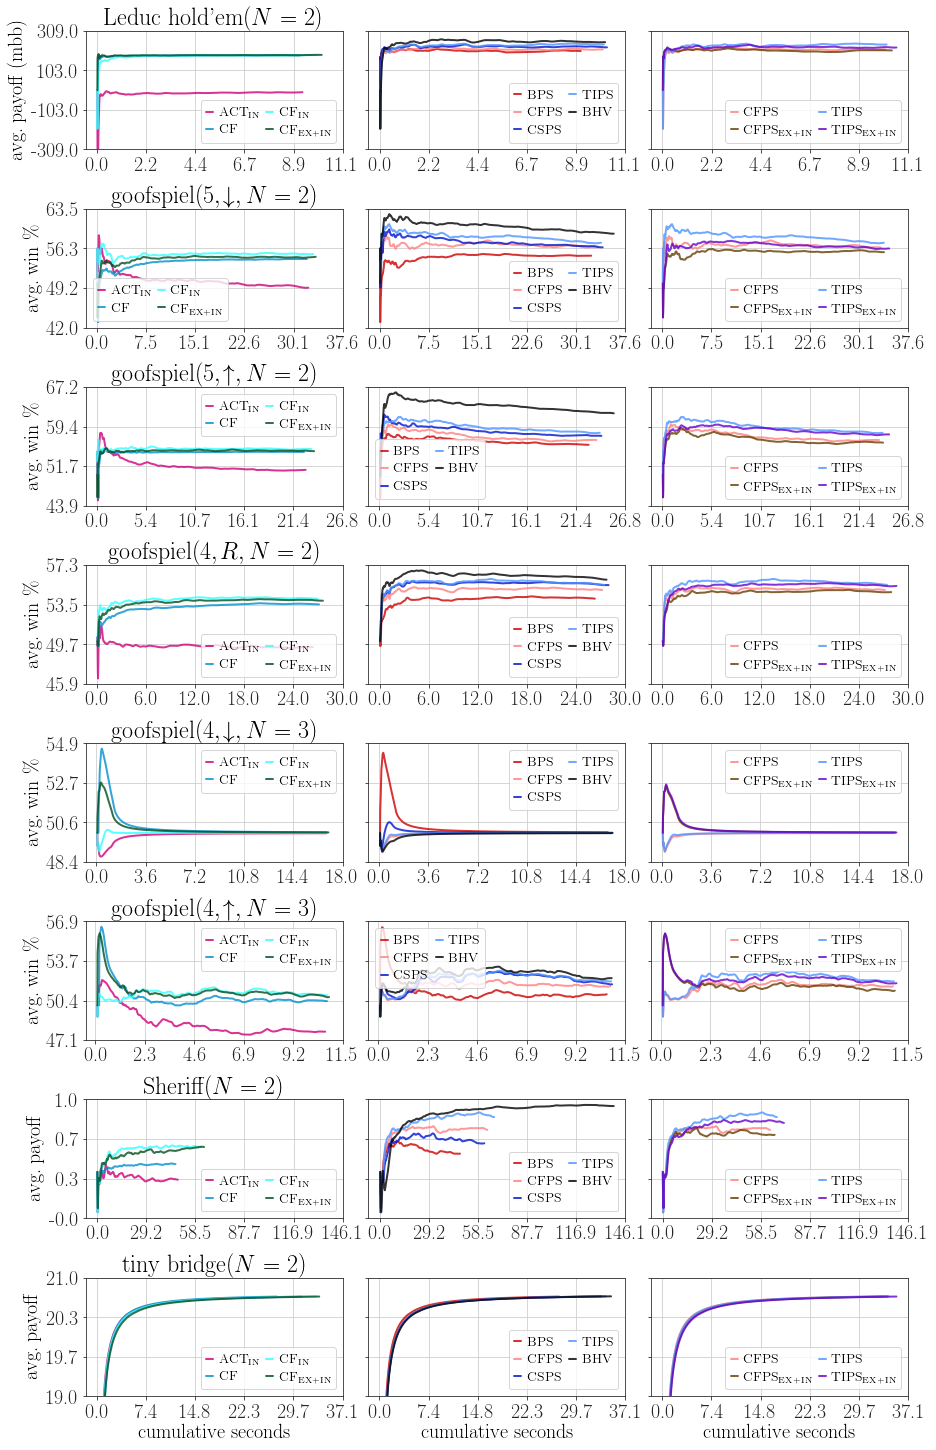

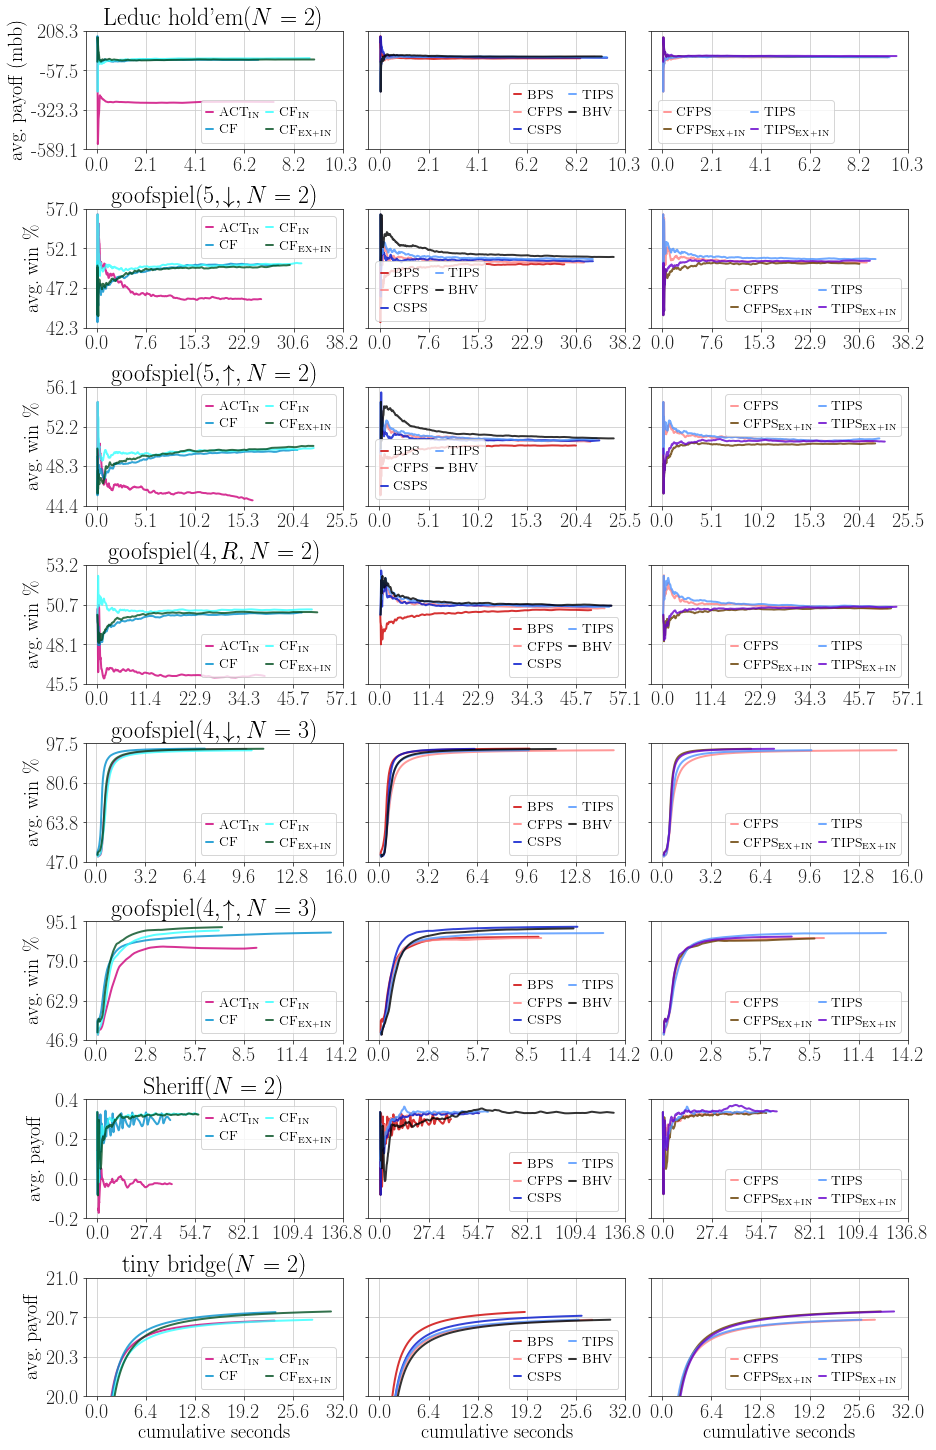

In [168]:
mcd_plt.set_plt_params(font_size=20)

ylim_by_game_list = [
    {
        'tiny_bridge': (19, 21),
        'leduc': (-309, 309),
    },
    {'tiny_bridge': (20, 21)},
]
modes = ['fixed', 'sim']
for k, mode in enumerate(modes):
    fig, axes_list = learning_curves_subplots(runtime_games, alg_comparisons)
    plot_all_runtime_learning_curves(axes_list, mode)
    ylim_by_game = ylim_by_game_list[k]
    for i, game_tag in each_game_in_runtime_learning_curve():
        if game_tag in ylim_by_game:
            axes_list[i, 0].set_ylim(ylim_by_game[game_tag])
    for i in range(axes_list.shape[0]):
        xticks = learning_curves_xticks(axes_list[i, 0])
        for j in range(axes_list.shape[1]):
            learning_curves_set_xticks(axes_list[i, j], xticks)
            learning_curves_set_yticks(axes_list[i, j])
            if j > 0:
                hide_ytick_labels(axes_list[i, j])
    for i, game_tag in each_game_in_runtime_learning_curve():
        ax = axes_list[i, 0]
        set_learning_curve_ylabel(game_tag, ax, avg=True)
        ax.set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[-1, 0:]:
        ax.set_xlabel('cumulative seconds')
    learning_curves_adjust_spacing()
    plt.savefig(f'../results/runtime_learning_curves.{mode}.{date}.pdf')

TypeError: learning_curve_data() missing 1 required positional argument: 'df'

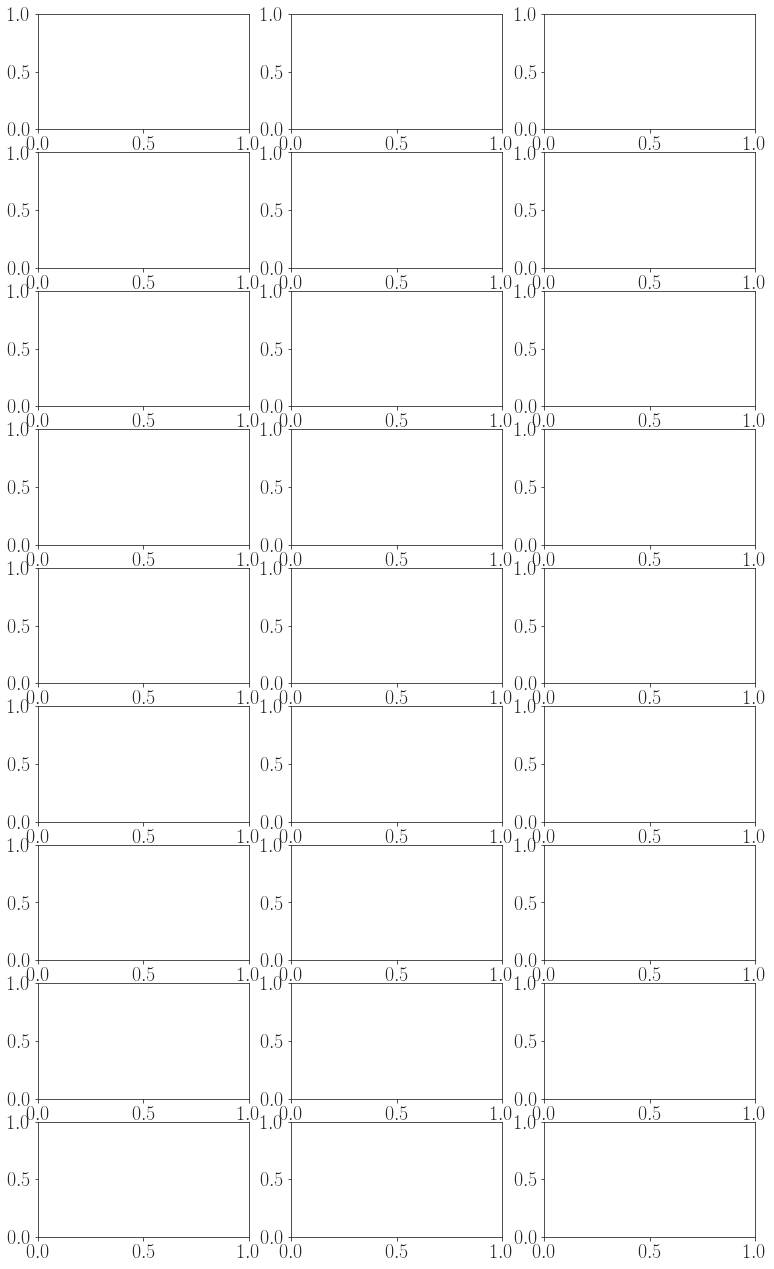

In [108]:
ylim_by_game = {
    'tiny_bridge': (19, 21),
    'tiny_hanabi': (8, 10),
}
games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='fixed',
                    algs=alg_group,
                    col_algs=list(all_algs))))
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j)
        elif j == 0:
            ax.set_ylabel(avg_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-2, 1:]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
# plt.savefig(f'../results/learning_curves.fixed.{date}.pdf')

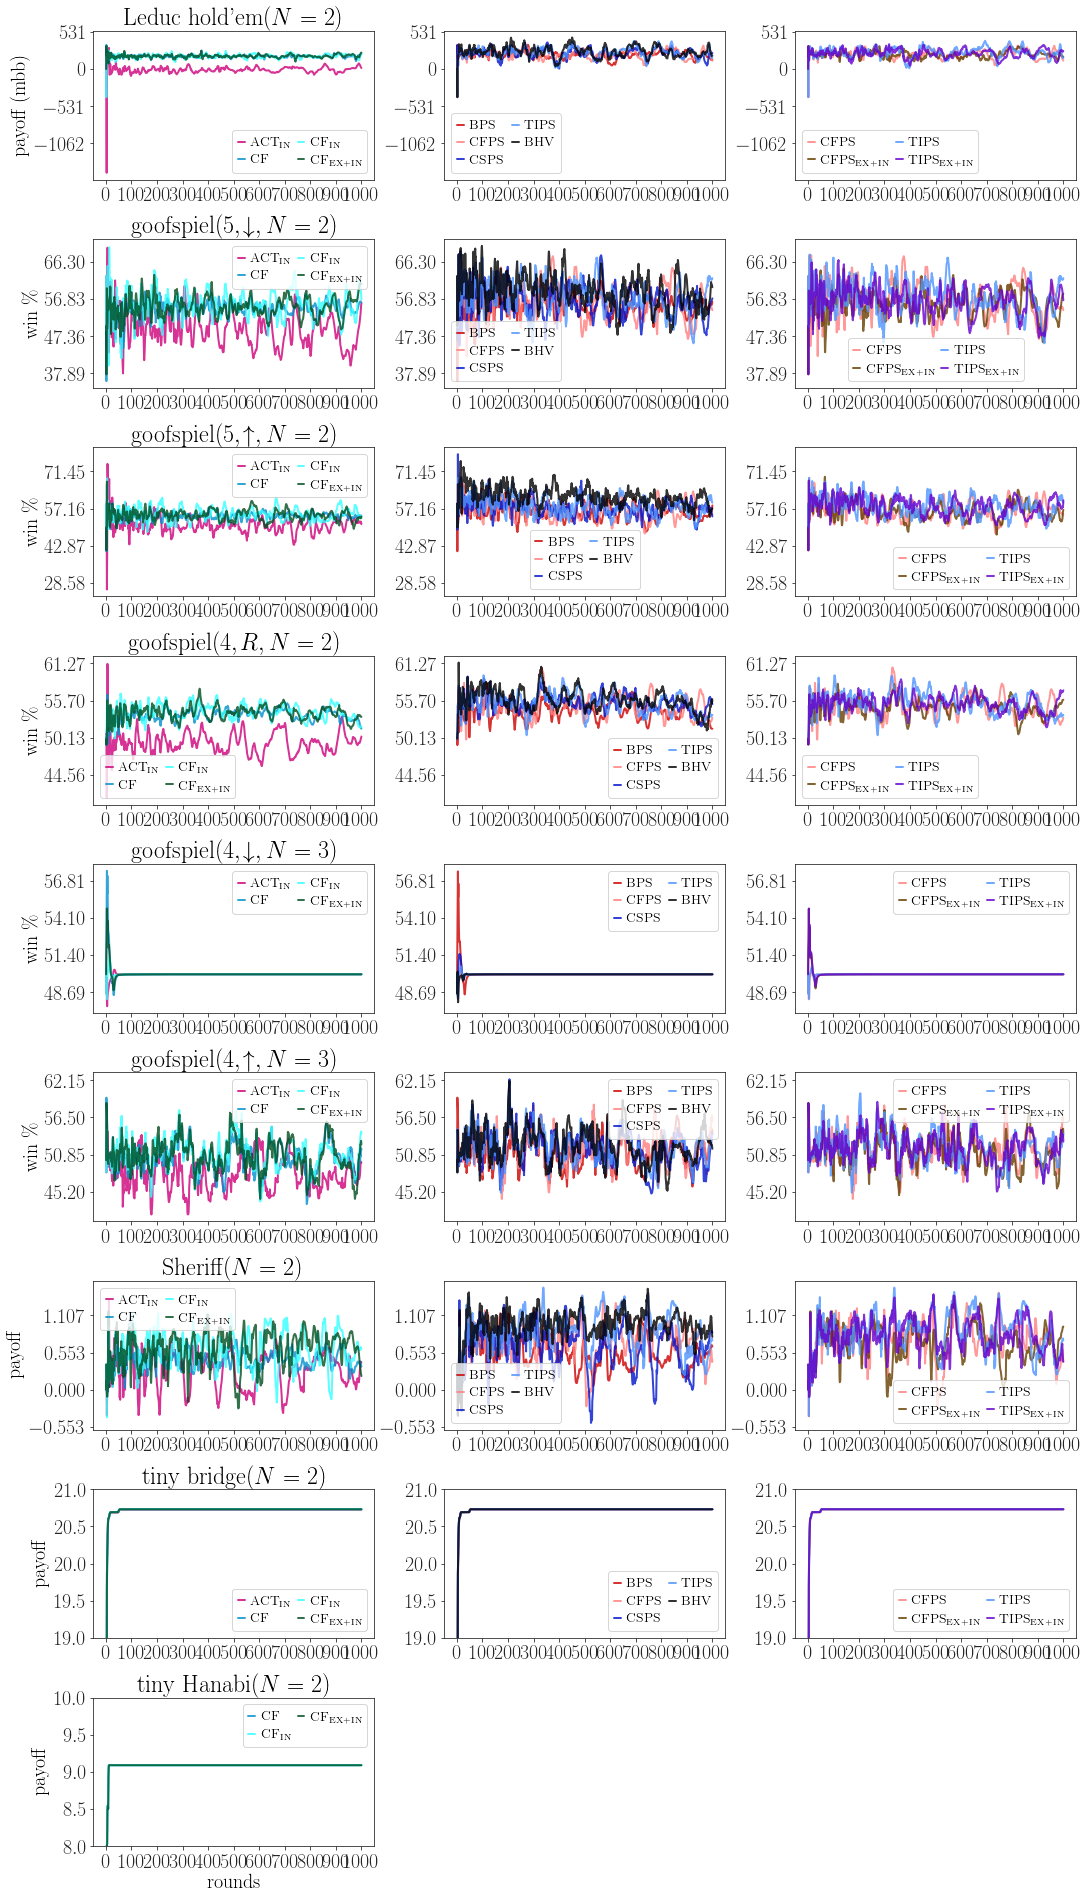

In [11]:
# ylim_by_game = {
# }

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='fixed',
                    algs=alg_group,
                    col_algs=list(all_algs))),
            False)
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j, avg=False)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j, avg=False)
        elif j == 0:
            ax.set_ylabel(inst_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'../results/learning_curves.fixed.inst.{date}.pdf')

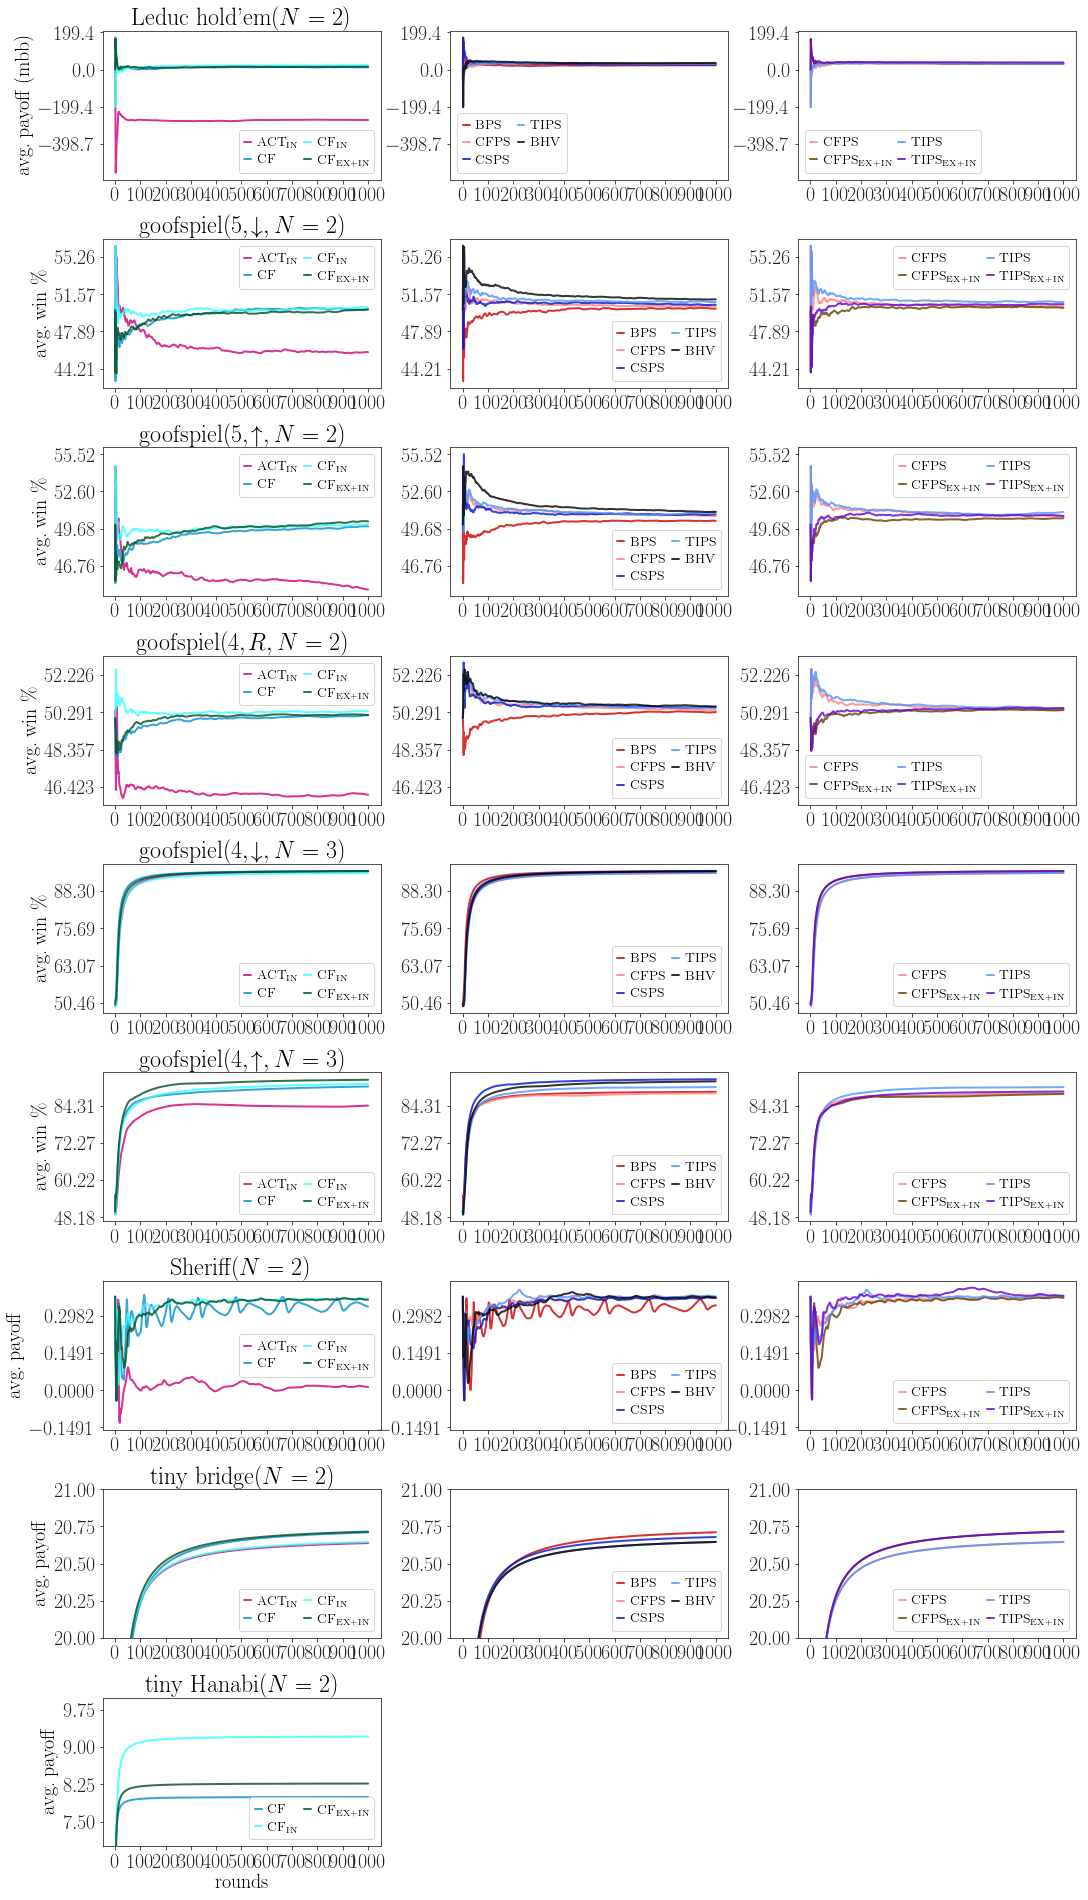

In [12]:
ylim_by_game = {
    'tiny_bridge': (20, 21),
    'tiny_hanabi': (7, 10),
}

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='sim',
                    algs=alg_group,
                    col_algs=list(all_algs))))
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j)
        elif j == 0:
            ax.set_ylabel(avg_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'../results/learning_curves.sim.{date}.pdf')

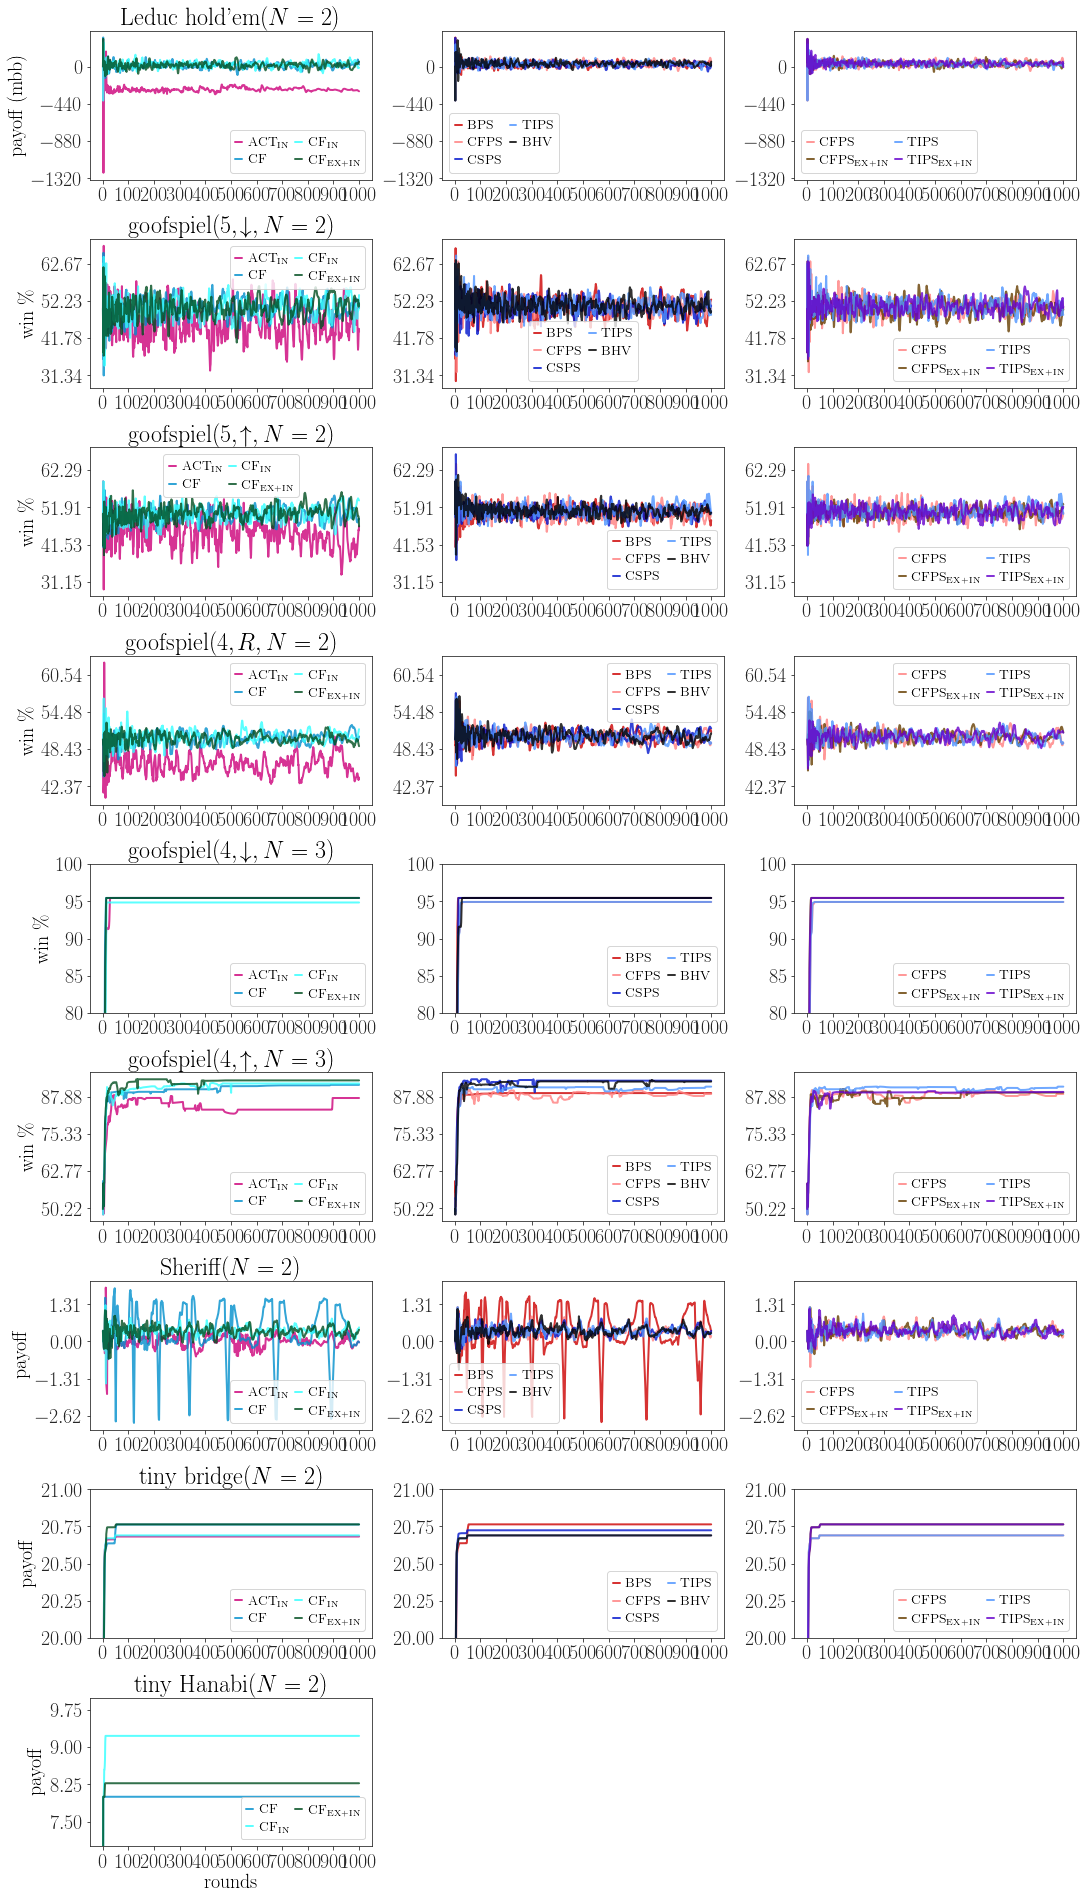

In [13]:
ylim_by_game = {
    'goofspiel_3p': (80, 100),
    'tiny_bridge': (20, 21),
    'tiny_hanabi': (7, 10),
}

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='sim',
                    algs=alg_group,
                    col_algs=list(all_algs))),
            False)
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j, avg=False)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j, avg=False)
        elif j == 0:
            ax.set_ylabel(inst_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'../results/learning_curves.sim.inst.{date}.pdf')

leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
tiny_hanabi


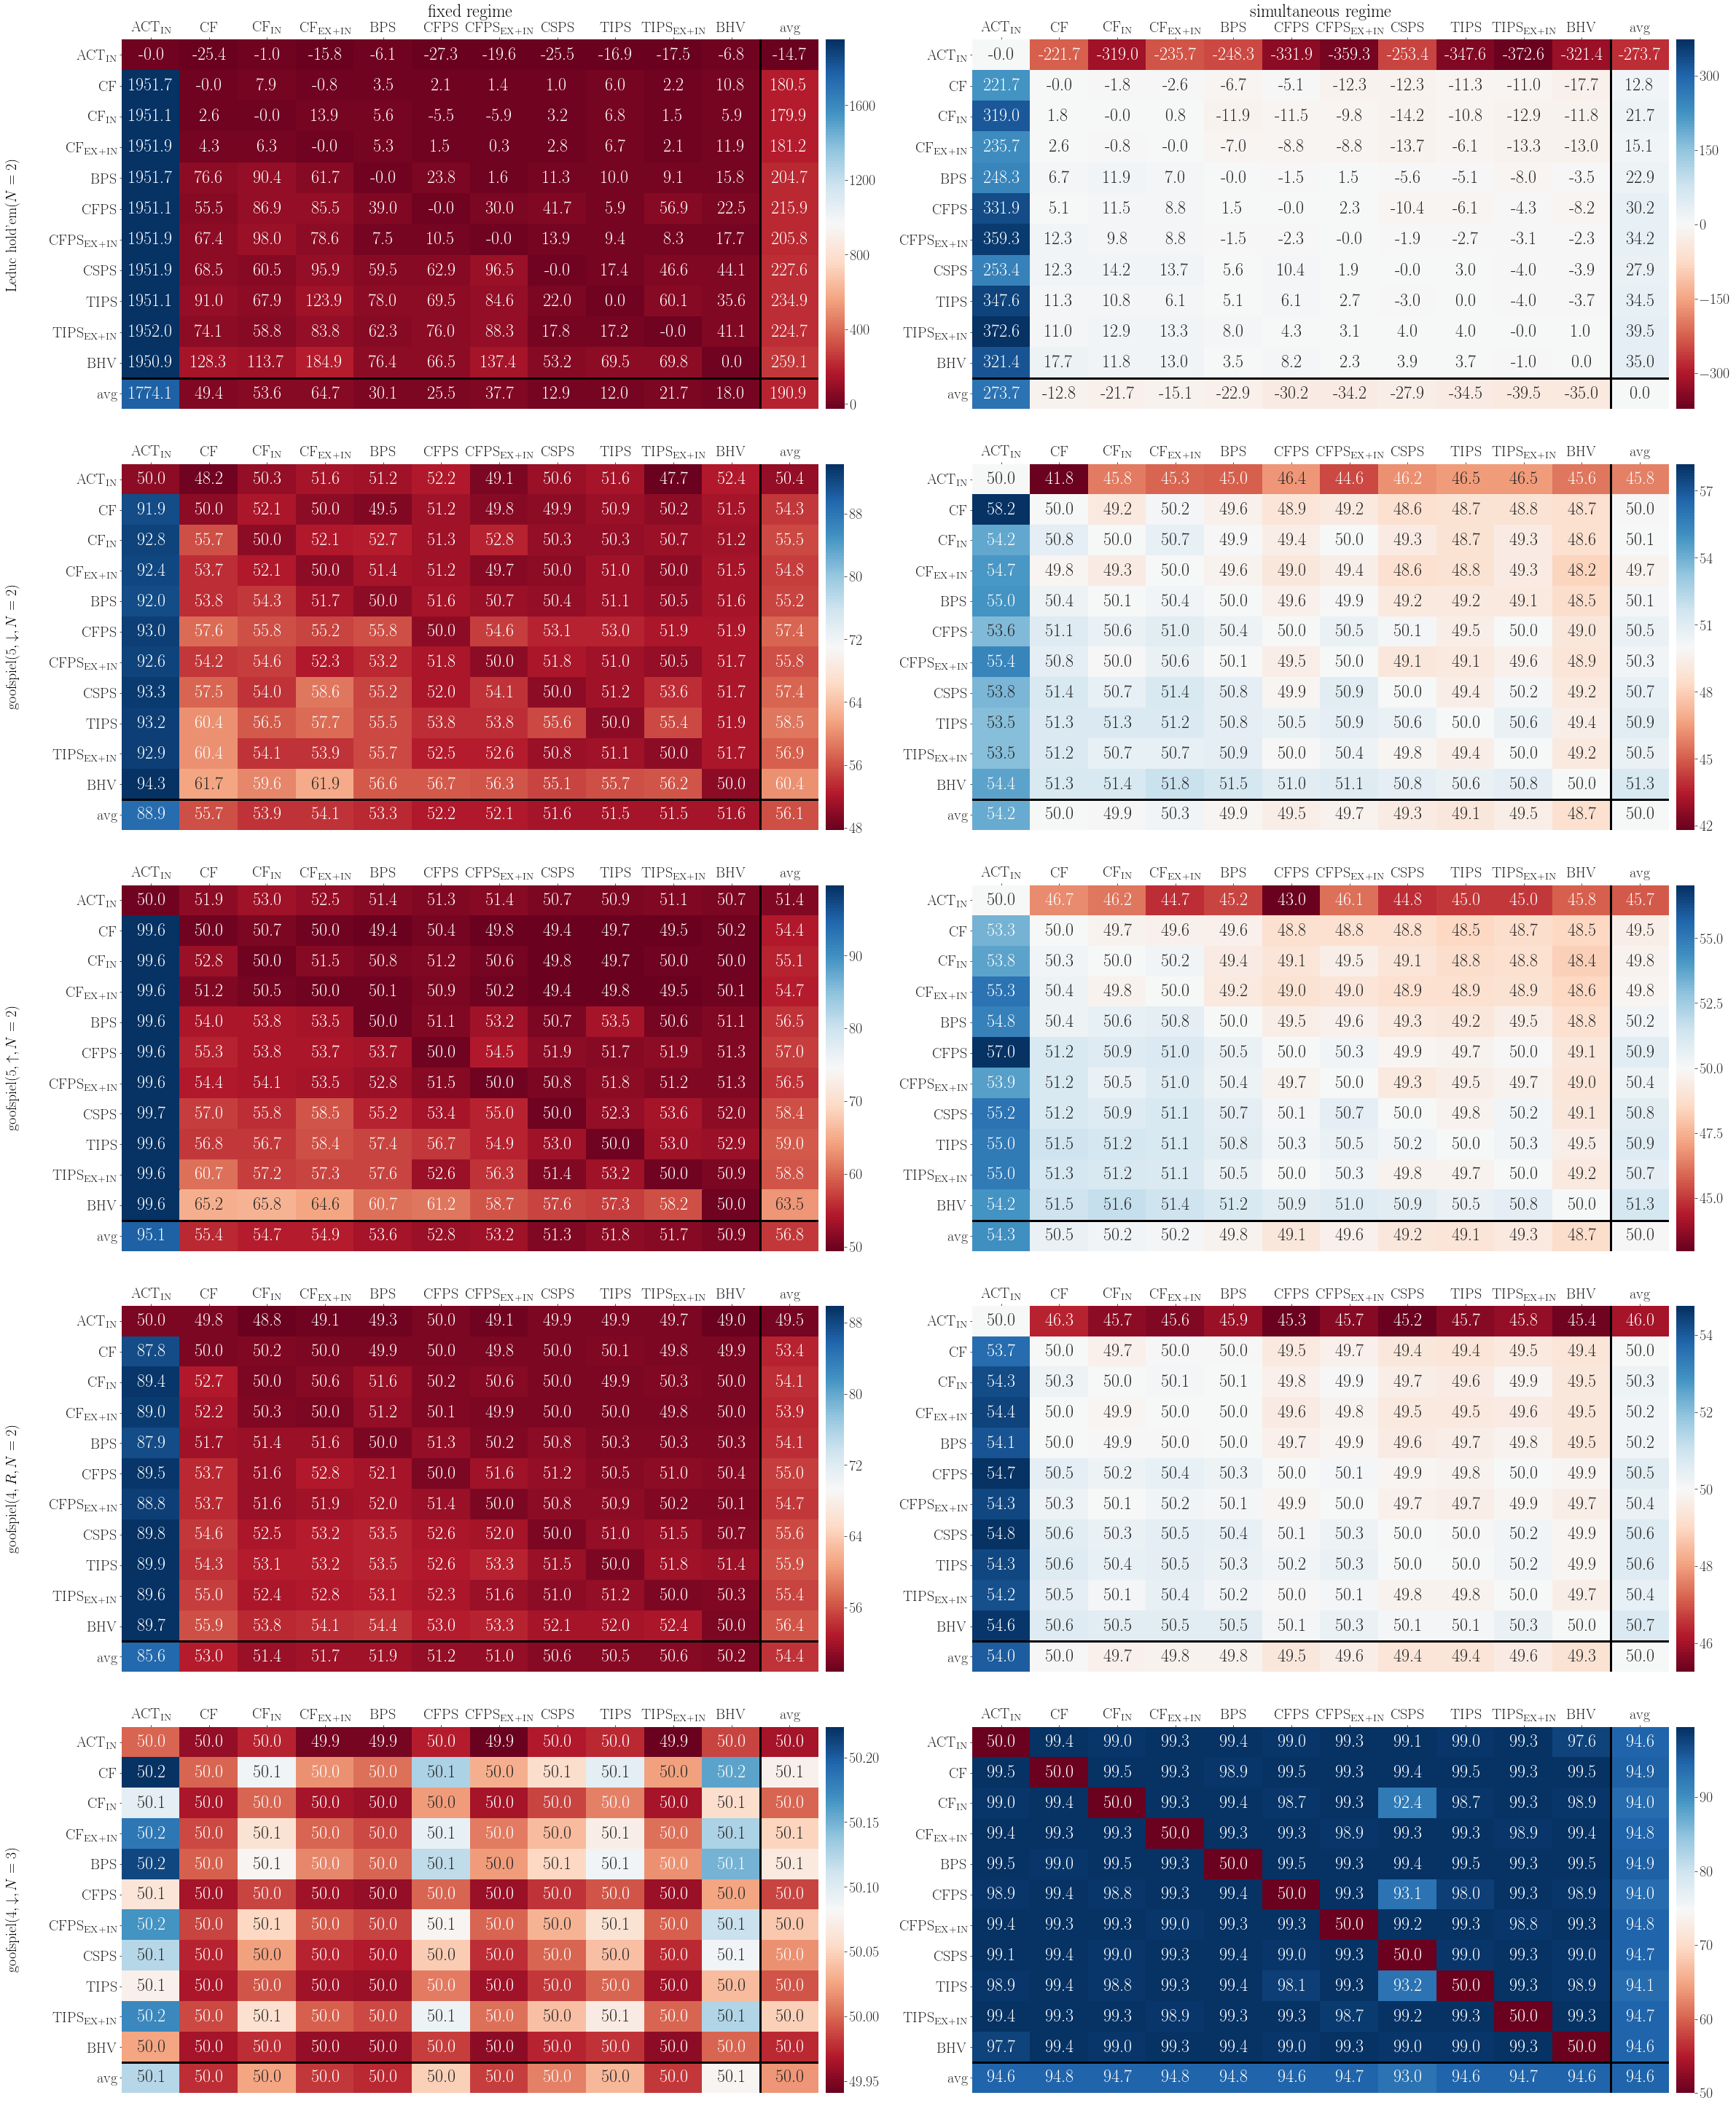

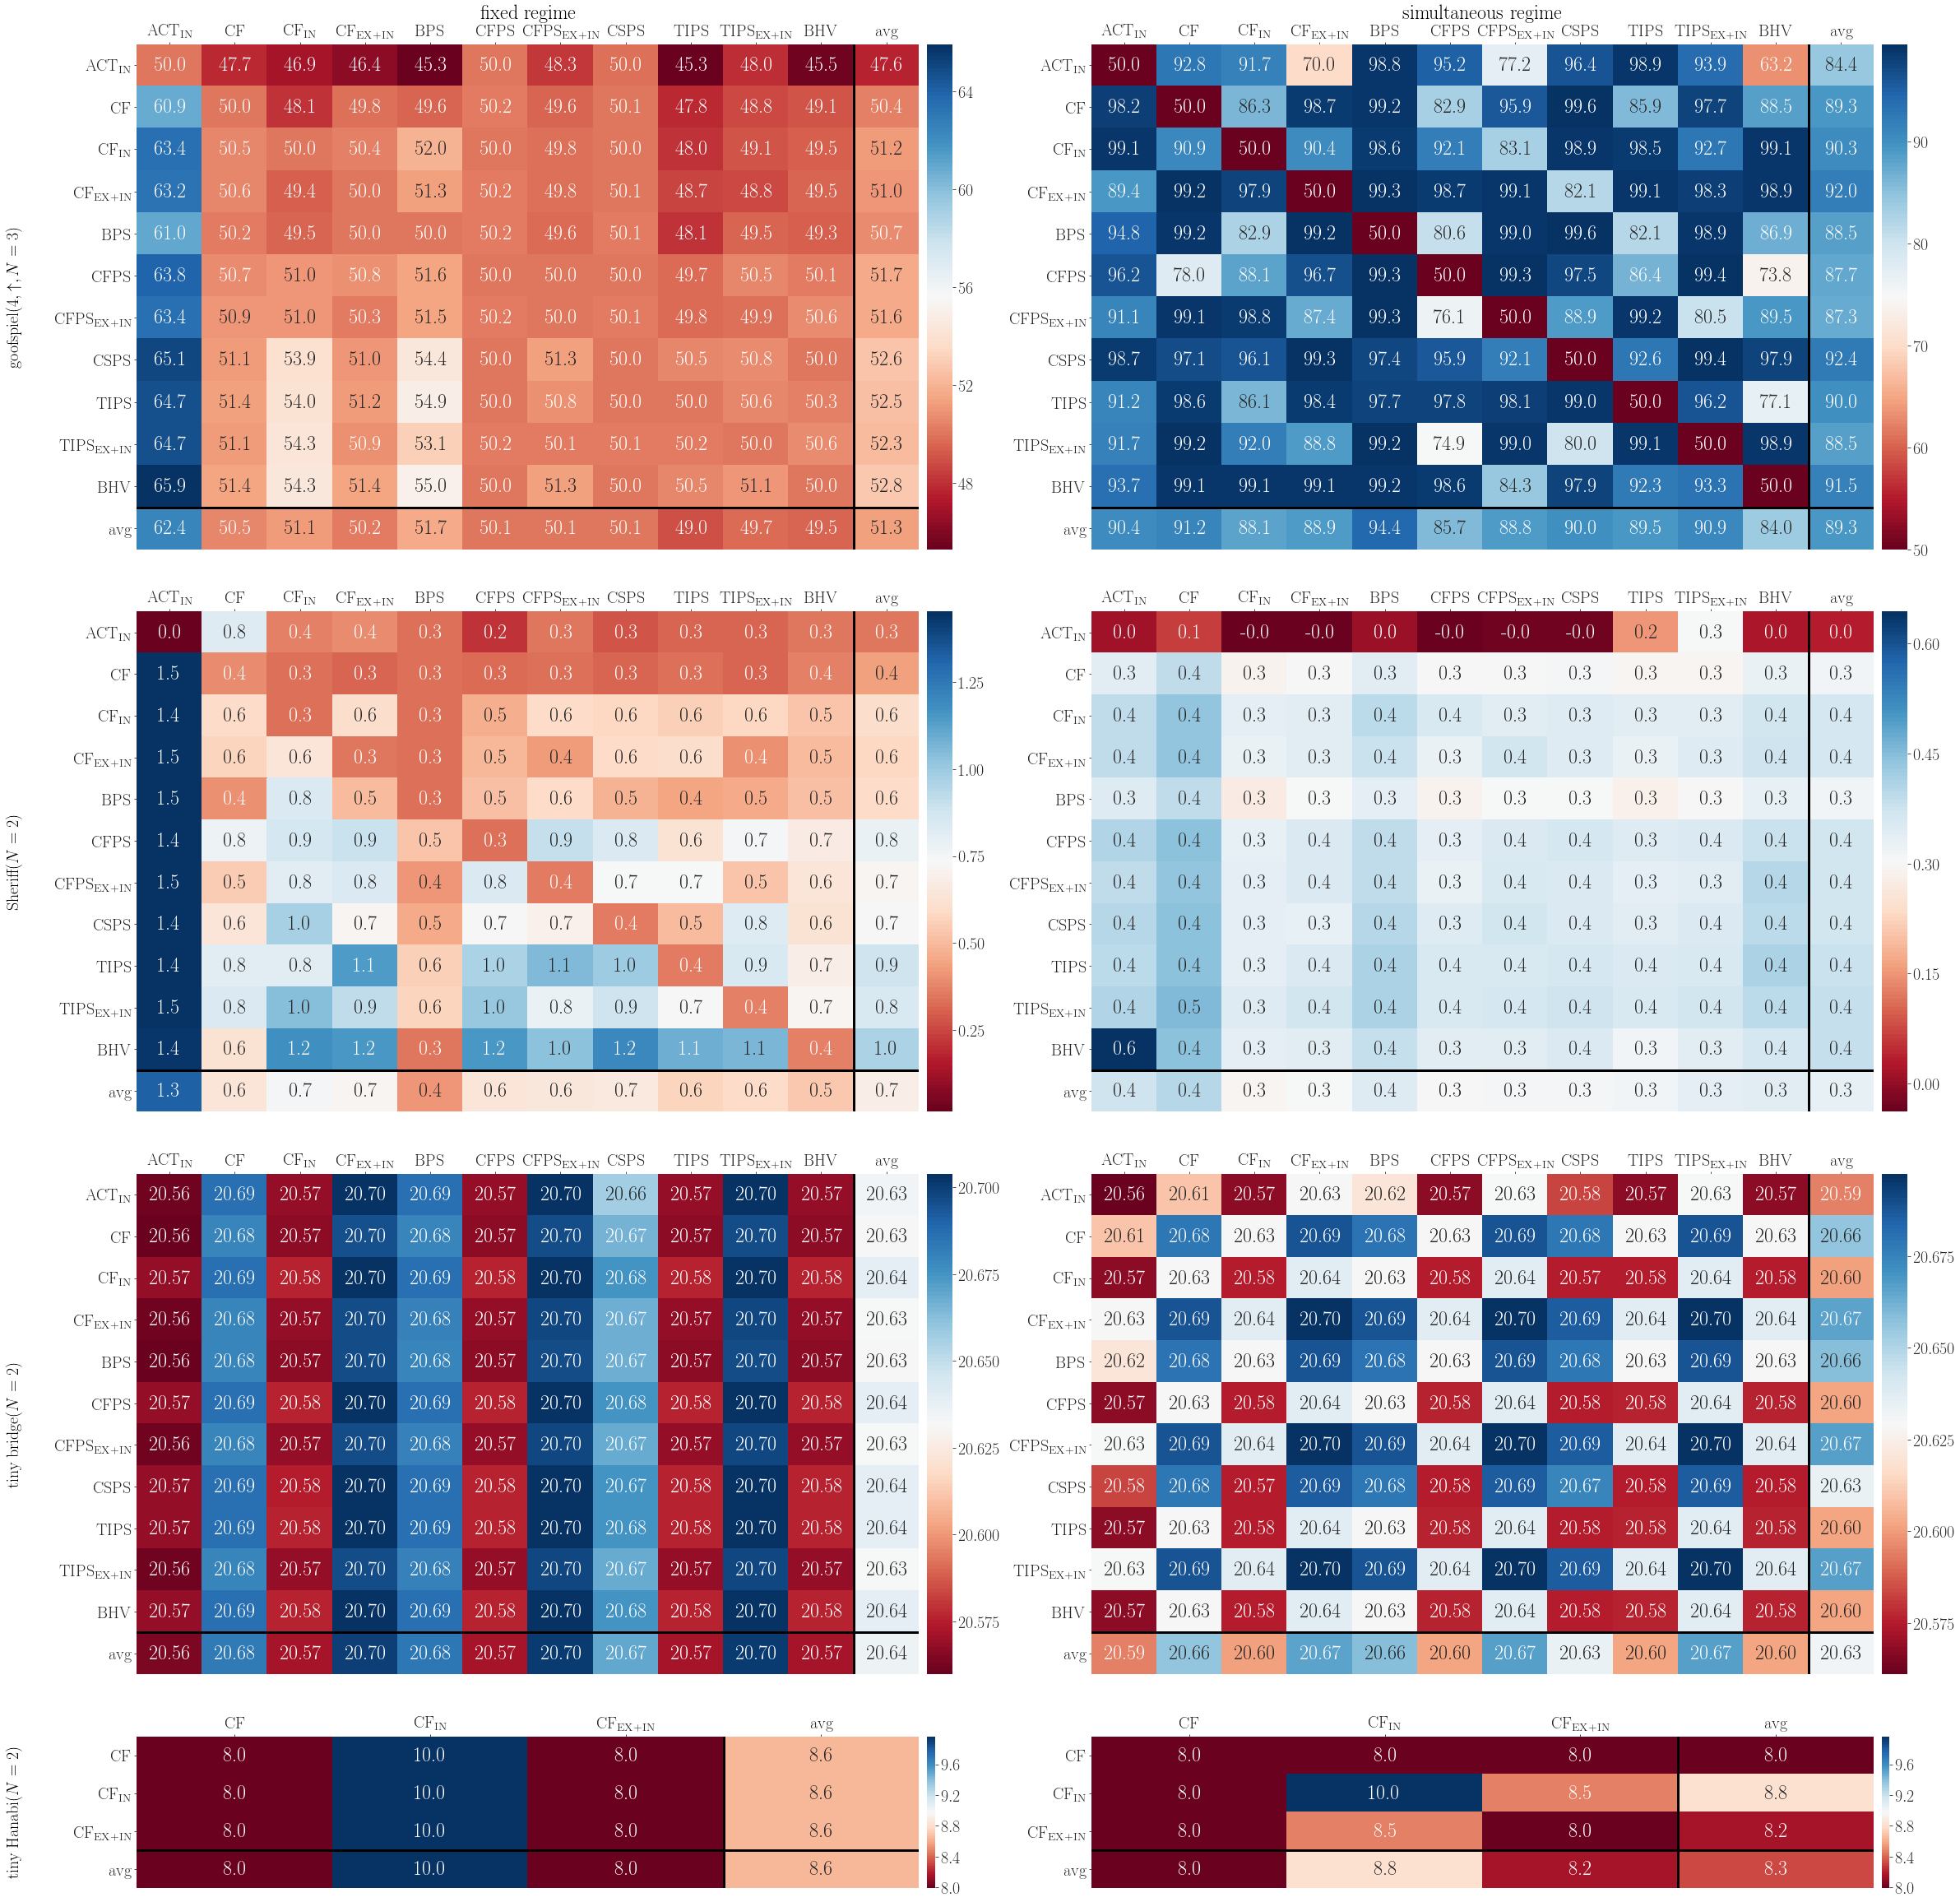

In [14]:
# mcd_plt.set_plt_params(font_size=24)

num_rounds = 501
num_cols = 2
games = data.games()
num_games1 = len(games)
num_games1 = int(np.ceil(num_games1 / 2))
fig, axes_list = plt.subplots(
    num_games1,
    num_cols + 1,
    squeeze=False,
    figsize=(33, 8 * num_games1),
    gridspec_kw={'width_ratios': [0.01, 1, 1], 'height_ratios': [1] + [0.99] * (num_games1 - 1)})
axes_list[0, 1].set_title('fixed regime')
axes_list[0, 2].set_title('simultaneous regime')

num_games2 = int(np.floor(len(games) / 2))
fig2, axes_list2 = plt.subplots(
    num_games2,
    num_cols + 1,
    squeeze=False,
    figsize=(33, 8 * num_games2),
    gridspec_kw={'width_ratios': [0.01, 1, 1], 'height_ratios': [1] + [0.99]*(num_games2 - 2) + [0.3]})
axes_list2[0, 1].set_title('fixed regime')
axes_list2[0, 2].set_title('simultaneous regime')

axes_list = np.concatenate([axes_list, axes_list2], axis=0)
for i, game in enumerate(games):
    print(game)
    axes_list[i, 2].sharex(axes_list[i, 1])
    axes_list[i, 2].sharey(axes_list[i, 1])
#     axes_list[i, 2].yaxis.set_visible(False)

    if game == 'tiny_hanabi':
        _df = data.data.query(
            ' & '.join([
                f'game_tag == "{game}"',
                'mode == "fixed"',
                f't < {num_rounds}',
                f'row_alg == {list(nf_algs)}',
                f'col_alg == {list(nf_algs)}',
            ]))
        _df = _df.pivot(index='t', columns=['row_alg', 'col_alg'],
                        values='value').mean().unstack()
    else:
        _df = mcd_tournament.without_br_row(data.time_avg_fixed_table(game, num_rounds))
        
    fmt = "0.1f"
    if is_leduc(game):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game):
        _df = goofspiel_score_to_win_percentage(_df)
        fmt = "0.1f"
    elif game == 'tiny_bridge':
        fmt = "0.2f"
    
    mcd_tournament.heatmap(
        _df,
        fmt=fmt,
        ax=axes_list[i, 1],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    if game == 'tiny_hanabi':
        _df = data.data.query(
            ' & '.join([
                f'game_tag == "{game}"',
                'mode == "sim"',
                f't < {num_rounds}',
                f'row_alg == {list(nf_algs)}',
                f'col_alg == {list(nf_algs)}',
            ]))
        _df = _df.pivot(index='t', columns=['row_alg', 'col_alg'],
                        values='value').mean().unstack()
    else:
        _df = data.time_avg_sim_table(game, num_rounds)
    if is_leduc(game):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game):
        _df = goofspiel_score_to_win_percentage(_df)
    
    mcd_tournament.heatmap(
        _df,
        fmt=fmt,
        ax=axes_list[i, 2],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    axes_list[i, 0].axis('off')
    axes_list[i, 0].text(0, 0.5, mcd_tournament.game_label(game),
                         horizontalalignment='left',
                         verticalalignment='center',
                         rotation=90,
                         transform=axes_list[i, 0].transAxes)
fig.tight_layout(pad=0.1)
fig.subplots_adjust(wspace=0.22, hspace=0.15)
fig.savefig(f'../results/heatmaps.{date}-1.pdf')

fig2.tight_layout(pad=0.1)
fig2.subplots_adjust(wspace=0.22, hspace=0.15)
fig2.savefig(f'../results/heatmaps.{date}-2.pdf')

# mcd_plt.set_plt_params(font_size=20)

In [16]:
_algs = [
    'A-EFR_IN',
    'CFR',
    'CFR_IN',
    'BPS-EFR',
    'CFPS-EFR',
    'CSPS-EFR',
    'TIPS-EFR',
    'BEHAV-EFR',
]
_alg_label_map = {
    'CFR': r'\textsc{cf}',
    'CFR_IN': r'\textsc{cf}\textsubscript{\INT}',
    'A-EFR_IN': r'\textsc{act}\textsubscript{\INT}',
    'CSPS-EFR': r'\textsc{csps}',
    'CFPS-EFR': r'\textsc{cf}',
    'TIPS-EFR': r'\textsc{tips}',
    'BPS-EFR': r'\textsc{bps}',
    'BEHAV-EFR': r'\textsc{bhv}',
}

def alg_labels(alg_tags):
    return [
      _alg_label_map[tag]
      for tag in alg_tags
    ]

def alg_sort_key(tag):
  return _algs.index(tag)


def alg_sort_keys(tags):
  return pd.Index([alg_sort_key(tag) for tag in tags], name=tags.name)


def with_sorted_algs(df):
  return df.sort_index(axis=0, key=alg_sort_keys)

In [17]:
fmt = r'{:.0%}\%'
num_rounds = 1000

In [18]:
_game_tags = [
    'goofspiel_ascending',
    'goofspiel_ascending_3p',
]
_modes = [
    'fixed',
    'sim',
]
_qs = ' & '.join(
    [
        f'game_tag == {list(_game_tags)}',
        f'mode == {list(_modes)}',
        f't < {num_rounds}',
        f'row_alg == {list(_algs)}',
        f'col_alg == {list(_algs)}'
    ]
)
_df = data.data.query(_qs)
_df = _df.pivot(
    index=['t', 'col_alg'],
    columns=['row_alg', 'mode', 'game_tag'],
    values='value'
).mean().unstack(level=[1, 2])
_df = with_sorted_algs(_df)
_df = _df.sort_index(axis='columns', level=1, key=(
    lambda x: pd.Index([_game_tags.index(y) for y in x], name=x.name)
))
_df = goofspiel_score_to_win_percentage(_df)
_df.index = pd.Index(alg_labels(_df.index))
print(_df.to_string(
    formatters=(
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
    )
))

mode                                           fixed                 sim                  fixed                    sim
game_tag                         goofspiel_ascending goofspiel_ascending goofspiel_ascending_3p goofspiel_ascending_3p
\textsc{act}\textsubscript{\INT}                & 51                & 45                   & 48                   & 86
\textsc{cf}                                     & 56                & 50                   & 51                   & 88
\textsc{cf}\textsubscript{\INT}                 & 57                & 50                   & 51                   & 92
\textsc{bps}                                    & 58                & 50                   & 51                   & 85
\textsc{cf}                                     & 58                & 51                   & 52                   & 84
\textsc{csps}                                   & 59                & 51                   & 52                   & 91
\textsc{tips}                                   

## Figure for HR-DT presentation

In [19]:
_algs = [
    'A-EFR_IN',
    'CFR',
    'TIPS-EFR',
]
_alg_label_map = {
    'CFR': r'CFR',
    'A-EFR_IN': r'$\approx$PGPI',
    'TIPS-EFR': r'EFR',
}
data = mcd_tournament.Data.load()
data.data = data.data.query(f'col_alg == {list(_algs)} & row_alg == {list(_algs)}')

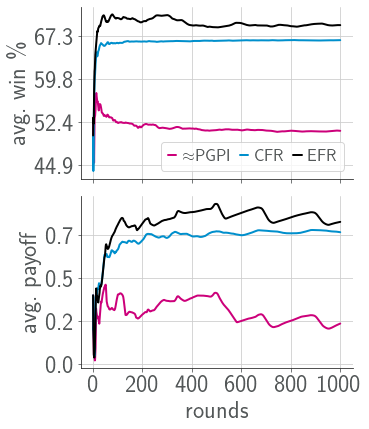

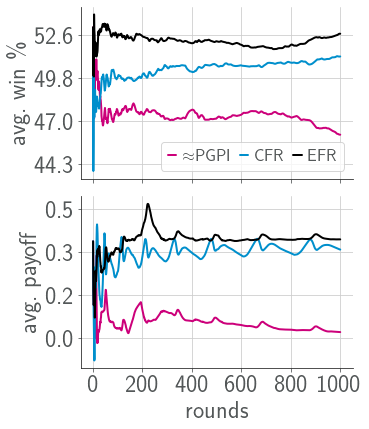

In [27]:
charcoal = '#545859'
mcd_plt.set_plt_params(font_size=24, use_serif=False, color=charcoal)

_alg_color = {k: v for k, v in alg_color.items()}
_alg_color['TIPS-EFR'] = 'black'

ylim_by_game = {}
games = ['goofspiel_ascending', 'sheriff']
modes = ['fixed', 'sim']
for mode in modes:
    fig, axes_list = learning_curves_subplots(games, [_algs])
    for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
        sharex_and_y_in_row(axes_list[i, :])
        for j, alg_group in enumerate([_algs]):
            ax = axes_list[i, j]
            _df = learning_curve_data(
                data.data.query(
                    learning_curve_query_string.format(
                        game=game_tag,
                        mode=mode,
                        algs=alg_group,
                        col_algs=list(_algs))))
            if is_goofspiel(game_tag):
                _df = goofspiel_learning_curve_config(_df, ax, j)
            elif j == 0:
                ax.set_ylabel(avg_learning_curve_ylabel)
            for alg in _df.columns:
                ax.plot(
                    _df.index.to_numpy() + 1.0,
                    _df[alg],
                    lw=2,
                    alpha=1,
                    label=_alg_label_map[alg],
                    color=_alg_color[alg]
                )
            if game_tag in ylim_by_game:
                ax.set_ylim(ylim_by_game[game_tag])
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
            ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
            ax.grid("on")
            ax.tick_params(colors=charcoal)
        for ax in axes_list[i, :]:
            learning_curves_set_ticks(ax)
    learning_curves_legend(axes_list[0, 0], ncol=3)
    axes_list[0, 0].set_xticklabels([])
    axes_list[-1, 0].set_xlabel('rounds')
    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0, hspace=0.1)
    sns.despine()
    plt.savefig(f'../results/learning_curves_hr_dt.{mode}.{date}.pdf', transparent=True)